In [1]:
#modeling sky subtraction model vs data points for 5/19/17 night
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec

import astropy

from astropy.io import fits
from astropy import units as u
from astropy.table import Table

from astropy import modeling
from astropy.modeling import models, fitting

from astropy import constants as cnst
%matplotlib inline
from matplotlib import pyplot as plt
import pipeline
from photutils import centroid_com
from astropy import units as u
from astropy import constants as const
import pandas as pd
import math as m
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
from astropy import constants as const
from astropy.stats import sigma_clip
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter


from astropy.visualization import quantity_support
quantity_support() #not sure about this line but stackoverflow...try w/o it later

from matplotlib import pyplot as plt

In [2]:
#amending pipeline code to get sky subtraction separate from 1d spec

def sky_subtract(comb,skyaps,model):    
    #plotting 2D to get skyaps right around the target
    plt.figure(figsize=(10,25)) #setting up fig size
    value = model[1]
    if model == 'linear':
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0)) #(1,0)
    elif model == ('poly',value):
        subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Polynomial1D(value)) #Linear1D(1/10,10)) #(1,0)
    elif model == ('combined',value):
        mymodel=(modeling.models.Polynomial1D(value) + modeling.models.Linear1D(1,0))
        subimg, models = comb.subtract_sky(skyaps, skymodel=mymodel)
    elif model == None:
        subimg, models = comb.subtract_sky(skyaps, skymodel=None)#subtracts mean
    else:
        print ("Model type or polynomial degree not recognized")
    return (subimg, comb, models)    #subtracted2D, original, fitted models per row


def show_image(comb, **kwargs): #comb-self
        """
        Matplotlib imshow of this image

        transpose image for blue side unless transpose=False is given

        if log=True is given,the whole image will be linearly rescaled to 1-100
        before log-ifying, possibly be vmin/vmax
        """
        from matplotlib import pyplot as plt

        kwargs.setdefault('interpolation', 'nearest')
        kwargs.setdefault('transpose', self.side=='blue')

        if kwargs.pop('log', False):
            safedata = self.data[np.isfinite(self.data)]
            #use vmin and vmax to rescale  1-100
            lmin = kwargs.pop('logmin', None)
            lmax = kwargs.pop('logmax', None)
            mx = lmax if lmax else np.max(safedata)
            mi = lmin if lmin else np.min(safedata)
            rescaleddata = ((comb.data - mi) / (mx - mi)) #comb-self
            rescaleddata[rescaleddata>1] = 1
            rescaleddata[rescaleddata<0] = 0
            d = np.log10(rescaleddata*99.+1.)
        else:
            d = comb.data #comb-self
        if kwargs.pop('transpose'):
            d = d.T
        res = plt.imshow(d, **kwargs)
        return res

    
def target_1d(subimg,specaps,ds):    
    flux, unc = subimg.extract_spectrum(specaps)
    #plotting 1D extraction of target
    plt.subplot(212)
    plt.step(ds.pixtowl(np.arange(len(flux))), flux)
    plt.title('1D Target Spectrum')
    plt.ylabel('flux -- but ask Erik to be sure (counts/units?)')
    plt.xlabel('wavelength')
    #based below limit choices on info on palomar dblspec webpage
    if header['IRAFNAME']=='FeAr.spec': #blueside
        print('choose 1D target spec axis limits for blueside')
        plt.xlim(2800, 7000) #3600,5800 
        plt.ylim(0, plt.ylim()[-1])
    elif header['IRAFNAME']=='henear.spec': #redside
        print('choose 1D target spec axis limits for redside')
        plt.xlim(4700, 11000)
        plt.ylim(0, plt.ylim()[-1])
    return (flux, unc)

#below kinda replaces 'target_1d' above
#defining a function will use later to extract target's 1D spectrum from whole 2D data file 
def extract_spectrum(side, subtracted_2d, aperture):
        """
        Extract a 1D spectrum the "simple" (non-Horne) way
        
        Parameters
        ----------
        aperture : 2-tuple
            The edges of the aperture along the spatial axis
            
        Returns
        -------
        spectrum : array
            A 1D extracted spectrum with the *sum* of the flux.
        unc : 1D array
            The flux uncertainty matching the extracted spectrum
        """

        apslc = aperture if isinstance(aperture, slice) else slice(*aperture)
        if side == 'red':
            d = subtracted_2d.data
        elif side == 'blue':
            d = subtracted_2d.data.T
        else:
            raise ValueError('unrecognized side ')
        spec = np.sum(d[apslc], axis=0)
        unc = np.sum(d[apslc]**2, axis=0) ** 0.5
        unsum_spec = d[apslc]
        return spec, unc, unsum_spec #spec-1D spectrum for target
#spec is summed data for each pixel column(wl) within the spec aps range

# Subtracting Instrument Noise

In [3]:
#Finding all data file for specific target and doing instrumentation noise subtraction
#stating specific files/names to search for later on


flatid = 'DomeFlat'
atlasfiles = fits.open('henear.fits') #use for creating dispersion solution later 
targetID = '79005021831220-Catch22'
all_side_files_target = 'DoubleSpec/20170518/red*.fits'

#determing what instumentation noise is
flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj(flatid,'DoubleSpec/20170518/red*.fits')[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
nfl = reduce_dblspec.create_normalized_flat(flats)   
header = atlasfiles[0].header    
    
#locating all files w/ the target & instrumentation noise subtraction
specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files_target)]
#specs is the inst. noise subtracted group of files with data from target    
    
print("This is lenspecs:",len(specs))

print('specs is the inst. noise subtracted group of files with data from target ')

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


This is lenspecs: 5
specs is the inst. noise subtracted group of files with data from target 


# Creating Dispersion Solution

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


used atlas plot limits for Red side


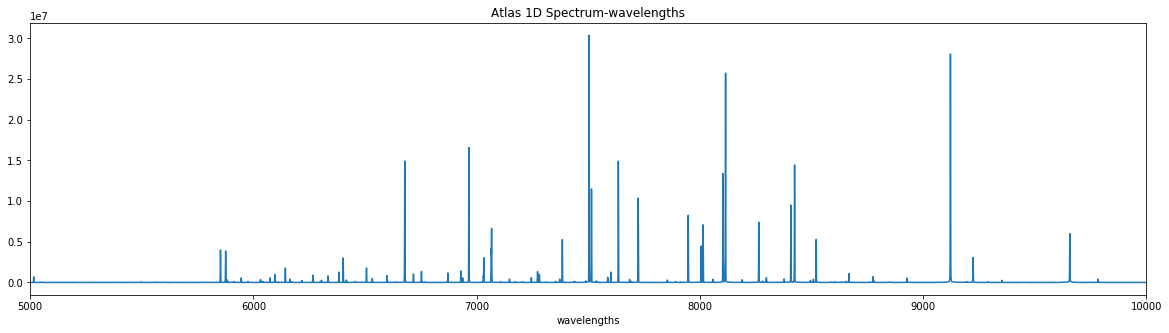

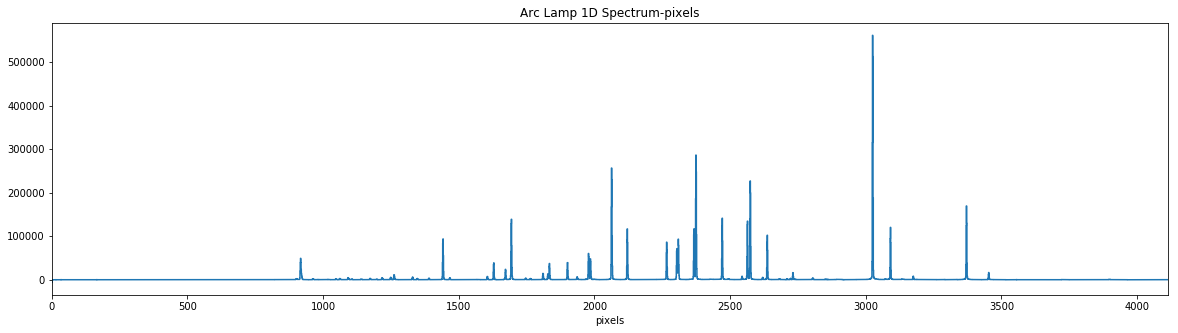

In [4]:
#creating a ds _ part one

#nameing all the datafiles needed
all_side_files_red10 = 'DoubleSpec/20170518/red*.fits' #redside
atlasfiles_red10 = fits.open('henear.fits') #NOAO atlas #redside
arcfiles_red10 = 'DoubleSpec/20170518/red0012.fits' #redside
linelist_red10 = reduce_dblspec.HENEAR_LINE_LIST

specset_red10 = pipeline.dispersion(all_side_files_red10, atlasfiles_red10, arcfiles_red10, linelist_red10,flatid)

/Users/dee/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


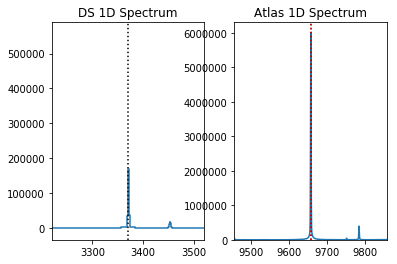

In [5]:
#creating a ds _ part two


#collecting guesses of matching lines from above graphs
#entering (px,wl)guesses & data
pipeline.guess_plot(3370,9657,specset_red10) #outputs (pixel guess, nearest wl/id in linelist)

#collect guesses here ~5 seems good
pixel_guesses_red10 = [3024,2373,2062,1672,3370]
atlas_lines_red10 = [9122.9674,8115.311,7635.106,7032.4131,9657.7863]
guesses_red10 = list(zip(pixel_guesses_red10, atlas_lines_red10)) #making tuples to pass into fcn later

/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


chose ds for redside
chose guesses for redside
Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480

Failed to find line ArI at wl=7125.82: "Guessed line's peak to base ratio is 1.5184423969745522, which is less than 10"
Failed to find line ArI at wl=7147.0416: "Guessed line's peak to base ratio is 5.64112705476983, which is less than 10"
Failed to find line NeI at wl=7173.9381: "Guessed line's peak to base ratio is 5.7128864055846185, which is less than 10"
Failed to find line ArI at wl=7206.9804: "Guessed line's peak to base ratio is 1.2169333577354096, which is less than 10"
Found line NeI at wl=7245.1666
Clipped 0 lines
Failed to find line ArI at wl=7272.9359: "Guessed line's peak to base ratio is 7.605442276448056, which is less than 10"
Found line HeI at wl=7281.349
Clipped 0 lines
Failed to find line ArI at wl=7353.293: "Guessed line's peak to base ratio is 1.440416352893276, which is less than 10"
Failed to find line ArI at wl=7372.1184: "Guessed line's peak to base ratio is 1.886015039320914, which is less than 10"
Found line ArI at wl=7383.9805
Clipped 0 lines
Failed to find

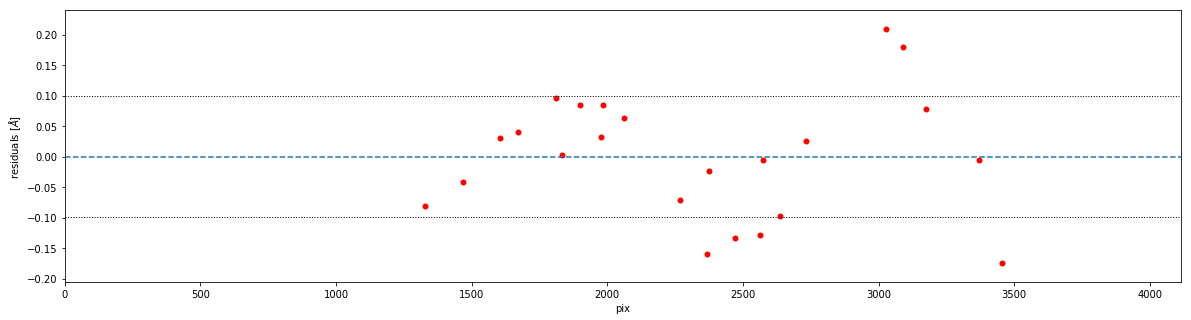

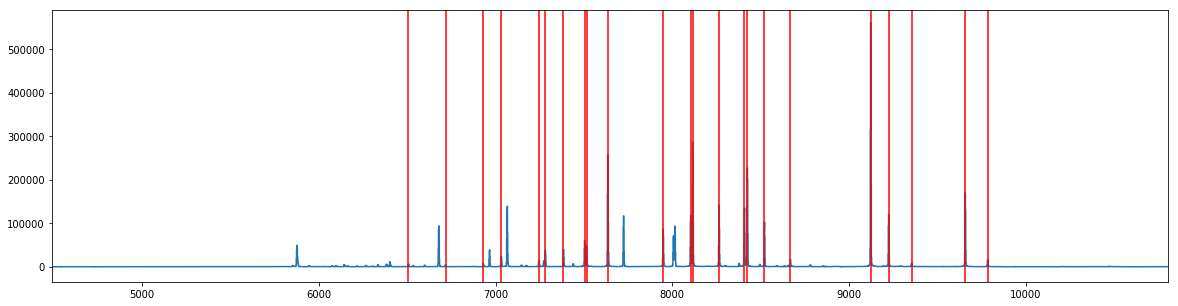

In [6]:
#creating a ds _ part three
ds_red10 = pipeline.goodness_of_matches(arcfiles_red10,guesses_red10,all_side_files_red10,atlasfiles_red10,linelist_red10,flatid);

#this is the final ds to apply to catch22 data for this entire nb

# Sky Subtraction & stacking - data still 2D

In [7]:
#stacking all those instrument-noise-subtracted target data files-help increase s/n 

comb = reduce_dblspec.combine_imgs(specs) #comb-all files data from target stacked
skyaps=[(20,33),(265,320)]#[(55,120),(190,350)] #target 35-260
#skyaps=[(30,110),(180,400)] 
model=('poly',2)

subimg2, comb2, fitmodels = sky_subtract(comb,skyaps,model)
#subimg2 is sky-subtracted, instumentation noise subtracted, stacked data
#comb2 is original instrumentation noise subtracted, stacked data
#fitmodels is sky lines fitted to 'model' type

<Figure size 720x1800 with 0 Axes>

# Extracting 2D target spectrum (reducing spatial parameters)



FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!
flux data shape: (226, 4104)
NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS  WL_PIX_CORRECTION DEFINED HERE!!!!!! 


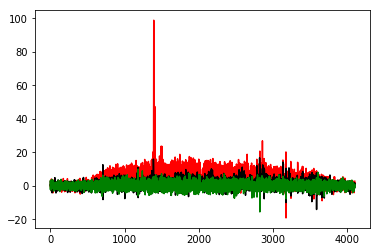

In [8]:
#first need to get 1D spectrum for each spatial pixel row in the 2D target data

#extracting target spec from whole 2d spec
target_aperature=(35,260) #target location

flux_data=[] #empty list to hold target 2d spec
apslc = np.arange(target_aperature[0],target_aperature[1]+1,1) #makes list for which rows to extracct spec from
#print (apslc) #as expected, +1 so doesnt cut off last value

#np.shape(subimg2.data)#(440, 4114)
for i in apslc:
    spec = subimg2.data[i]#subimg2 is sky-subtracted 2D spec #this is every row's spec...
    
    #need to change if suming multiple pixel rows
    spec = spec[10::] #chops first 10 flux values in spectral (wl) direction-crazy osscillations
    flux_data.append(spec) #collects a list of every row's spec within the target location
flux_data=np.array(flux_data)   
print("FLUX_DATA IS THE TARGET'S 2D SPEC WILL WANT TO USE - ENTIRE REDSIDE (minus first 10 wls), NOT HALPHA ISOLATED!!!!!!!!!!!!!!!!!!!!!!!" )
#need to find a way to sum over diff ranges of apslc 

#defining spectral correction factor (try to fit this into loop above later on)
wl_pix_correction = 10 #this wont affect spatial axes pix values, only amount of flux but thats negligible


plt.plot(flux_data[145],color='r')#near galaxy center
plt.plot(flux_data[45],color='k') #near galaxy edge
plt.plot(flux_data[224],color='g')#near opposite galaxy edge

print('flux data shape:', np.shape(flux_data)) #(226, 4104)
print('NOTE THIS CELL CUTS OFF FIRST 10 PIXELS OF DATA FROM ENTIRE CCD SIZE DATASET DUE TO OSCILLS ', 
      'WL_PIX_CORRECTION DEFINED HERE!!!!!! ')

# Continnum Subtraction for Entire Target

shape new: (226, 4104)
new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array


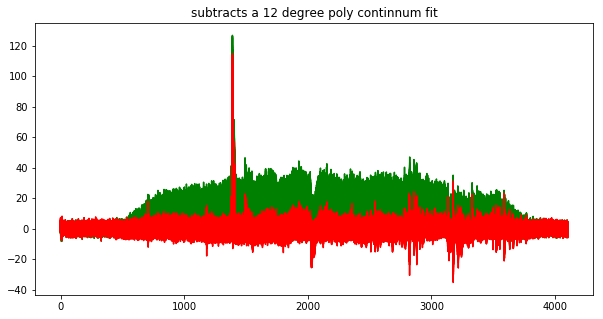

In [9]:
#good
#fitting continum for entire target now

#want to fit continum using a low-order poly (linear even??) for each spatial pix(row)
spatial_indexes = np.arange(0,len(flux_data))
new = []


for row in flux_data: #i isnt indiv data its each spatial row of data
    xpix = np.arange(0,len(row),1) #lists pixels by index
    polydeg = 12 #what degree of line to fit to continnum
    poly = np.poly1d(np.polyfit(xpix,row, polydeg)) #this determines the fit of the continum
    spec_subtracted = row - poly(xpix)
    new.append(spec_subtracted)
new = np.array(new)

divide = 4104 #number of spectral pixels in target data 
amtofrows = int(len(new)/divide) #also ensured int not float
plt.figure(figsize=(10,5))

print('shape new:',np.shape(new))

plt.plot(flux_data.T, color='g'); #original data
plt.plot(new.T,color='r'); #continum subtracted data
plt.title('subtracts a {:} degree poly continnum fit'.format(polydeg))

print('new is the name of continum subtracted (and inst & sky subtracted, spatially reduced) 2d target data array')




/Users/dee/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


5 target files located
choose 2D spec for redside
choose 1D target spec axis limits for redside


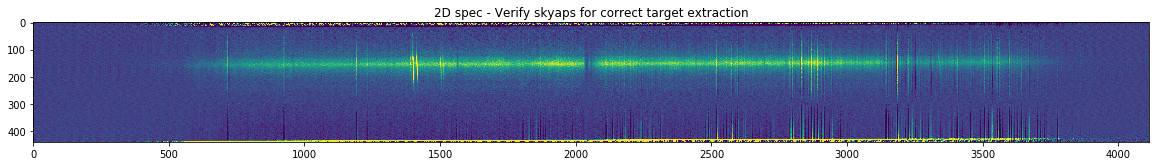

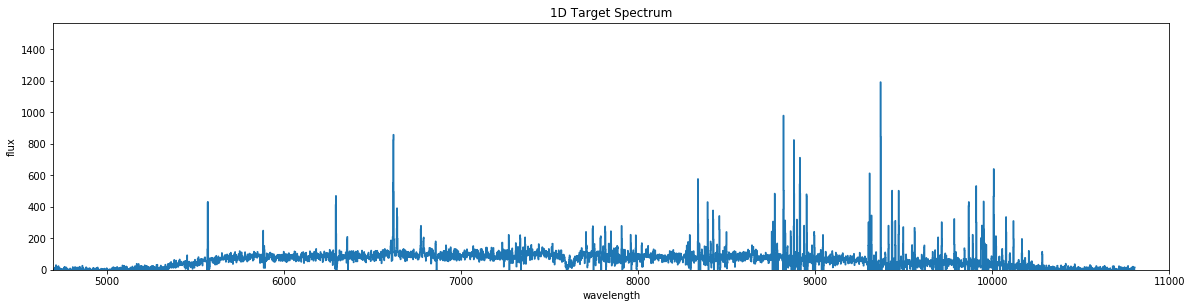

In [10]:
#plotting a 1D for AAS233

skyaps_red10 = [(20,33),(265,320)]# [(20,33),(265,320)]
specaps=(215,250)
vmax=40
vmin=-10
model= 'linear' #('poly',3)

flux_1d,unc_1d,subimg_1d = pipeline.sky_subtract(targetID,skyaps_red10,ds_red10,all_side_files_red10,atlasfiles,all_side_files_target,flatid,specaps,vmax,vmin,model)

   

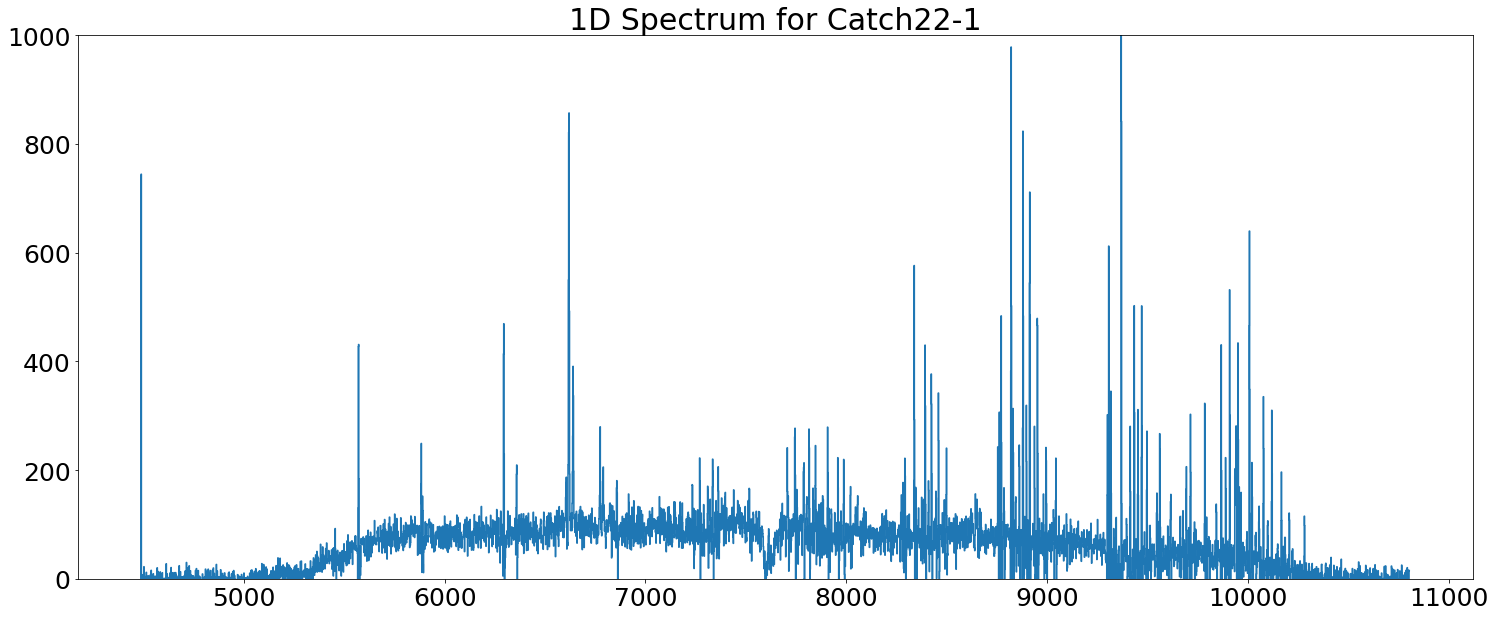

In [11]:
#plotting just 1d spectrum for AAS poster

plt.figure(figsize=(25,10))
plt.step(ds_red10.pixtowl(np.arange(len(flux_1d))), flux_1d)
plt.title('1D Spectrum for Catch22-1', SIZE=30) #via Halpha Gaussians with ErrorBars___fromzoomed_means', SIZE=25)
#plt.xlabel('RADIUS in Kpc',fontsize=20)
#plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0,1000)
plt.savefig('Catch22_1_1dspectrum.pdf', format='pdf', dpi=1000)

(0, 100)

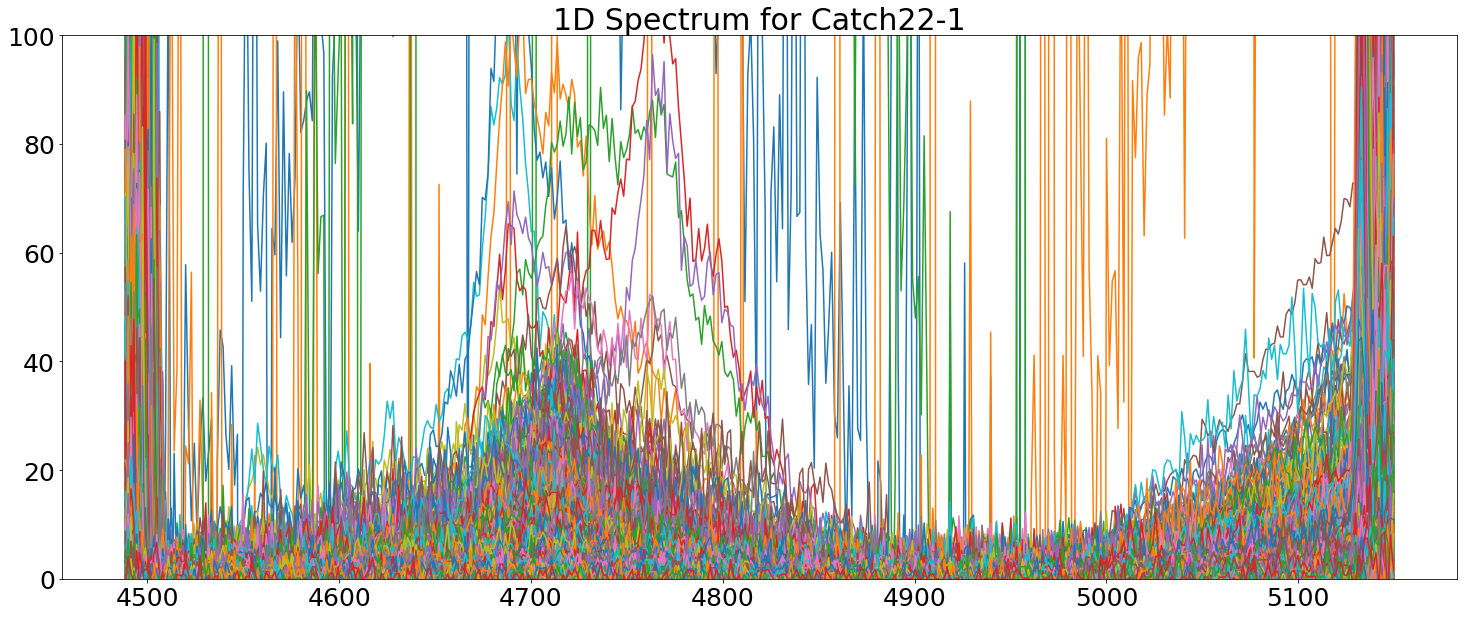

In [12]:
#plotting just 1d spectrum for AAS poster
plt.figure(figsize=(25,10))
plt.plot(ds_red10.pixtowl(np.arange(len(subimg2.data))), subimg2.data)
plt.title('1D Spectrum for Catch22-1', SIZE=30) #via Halpha Gaussians with ErrorBars___fromzoomed_means', SIZE=25)
#plt.xlabel('RADIUS in Kpc',fontsize=20)
#plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0,100)


In [13]:
#plt.showimg(comb2)

### Determining H-alpha wl range

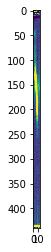

In [14]:
#determining better halpha range

#plt.figure(figsize=(2,15))

#using FULL ccd pix range
testingthis=subimg2.data[:,1396:1409]
vmin=-10
vmax=45
plt.imshow(testingthis,vmin=vmin,vmax=vmax)#add in ,aspect='auto', to get square pixels
#plt.ylim(50,250)
#plt.xlim(1380, 1400)

#conclusions
ha_range_fullccd = (1396, 1409)
ha_range_missing10 = (1386,1399)
harange_if10missing = flux_data[:,1386:1399] #flux_data off by 10 so subtract 10 from usual h-alpha's wl-in-pixspace range 



# Getting Galaxy Spatial Core Pix Value
### First Making 1D Spectrum
### CORE via FULL CCD SPECTRUM

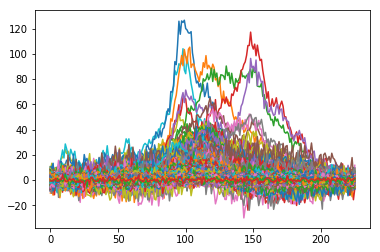

In [15]:
plt.plot(flux_data);

shape (226, 1)
x: 117.15085246346564 y: 0.0 y is the spatial core location still in pixels & in the Reduced spectral range
to get full plate scale pix value add 35 and 10 from 1D spec cut due to oscillations
GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL: 152.15085246346564
SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!
double check corrections after decide about 10 pix cut around ln[8]


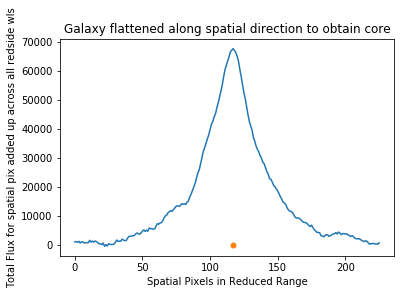

In [16]:
#USING FULL CCD SPECTRUM
#hack way of doing without a nice function from 1st cell

#flattening to be along spatial direction (histogram like)
flux_array = np.sum(flux_data,axis=1) #explicitly making an array
flux_array2d = flux_array[:, np.newaxis] #need 2d for centroiding


print('shape',np.shape(flux_array2d))
x_galcore, y_galcore = centroid_com(flux_array2d) #actually doing the centroiding

#plotting
plt.plot(flux_array2d);
plt.plot(x_galcore, y_galcore ,'.',markersize=10)
plt.xlabel('Spatial Pixels in Reduced Range')
plt.ylabel('Total Flux for spatial pix added up across all redside wls')
plt.title('Galaxy flattened along spatial direction to obtain core')

#below is amt of pix to add to target pix value to get matching plate pix #doesnt help total len tho
space_pix_correction = target_aperature[0] #from ln[9] in 1d target extract; maybe need to do this->#10 from pix cut from oscill in 1D
spatial_core_pix = x_galcore + space_pix_correction #(adds 35 to correct from target extraction),(10 from oscillations doesnt affect this b/c of spectral collapse in sum)

#conclusions
print('x:',x_galcore,'y:',y_galcore, 'y is the spatial core location still in pixels & in the Reduced spectral range')
print('to get full plate scale pix value add {:} and 10 from 1D spec cut due to oscillations'.format(target_aperature[0]))
print('GALAXY CORE (based on entire red side plate scale) IS AT SPATIAL PIXEL:',spatial_core_pix)
print('SPACE_PIX_CORRECTION DEFINED HERE!!!!!!!')
print('double check corrections after decide about 10 pix cut around ln[8]')

### CORE along spatial axis via TWO SECTIONS

shape of first section: (226, 50) matches shape of second section: (226, 50)
shape of first section 2d: (226, 1)
shape of second section 2d: (226, 1)
first section centroid x,y: 119.58596554138133 0.0
second section centroid x,y: 119.82357971072318 0.0
This is the average pixel value of the core BEFORE spatial cutout corrections 119.70477262605226
Pixel Value of core along spatial axis wrt full CCD size 154.70477262605226


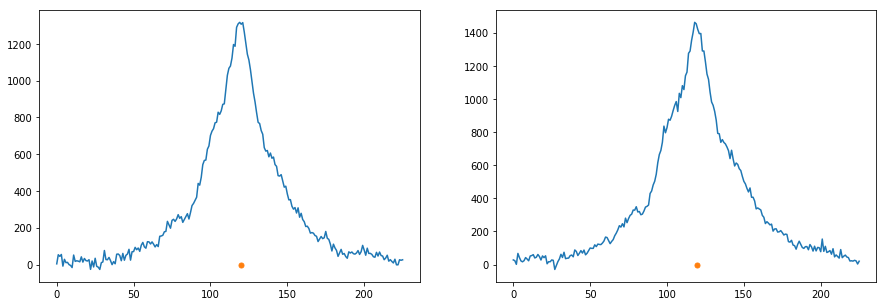

In [17]:
#USING SECTIONS SURROUNDING HALPHA WL RANGE
np.shape(flux_data)#(226,4104) #note that this is missing those 10 wl's
#also note flux_data is continuum subtracted

#below for reference
#harange_if10missing = flux_data[:,1386:1399] #flux_data off by 10 so subtract 10 from usual h-alpha's wl-in-pixspace range 
#plt.plot(harange_if10missing[11]); #saw clear ha peak so good

#making arrays surrounding h-alpha
upperha = 1399
lowerha = 1386
width_sections = 50
upper_one = lowerha - 1 #just to give it some distance
lower_one = upper_one - width_sections
lower_two = upperha + 1 #needed more distance (near&below core H-alpha leaks into this range so IF change ha range then make this 5 a 1 )
upper_two = lower_two + width_sections
first_section = flux_data[:,lower_one:upper_one]
second_section = flux_data[:,lower_two:upper_two]
print('shape of first section:', np.shape(first_section), 'matches shape of second section:', np.shape(second_section))
#plt.plot(second_section[120]); #tried many diff row values for both sections here - satisified correct


#collapsing both sections in the spatial direction (histogram like)
first_section_sum = np.sum(first_section,axis=1) 
first_section2d = first_section_sum[:,np.newaxis] #2d required to centroid
second_section_sum = np.sum(second_section,axis=1)
second_section2d = second_section_sum[:,np.newaxis] #2d required to centroid
print('shape of first section 2d:', np.shape(first_section2d))
print('shape of second section 2d:', np.shape(second_section2d))


#does the centroiding
x_first, y_first = centroid_com(first_section2d)
x_second, y_second = centroid_com(second_section2d)
print('first section centroid x,y:',x_first,y_first)
print('second section centroid x,y:',x_second,y_second)



#verify by plots
f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(first_section2d);
ax2.plot(second_section2d);
#note below had to reverse xy centroids to visualize correctly, not sure why it inverted tho...
ax1.plot(x_first,y_first, '.', markersize=10)
ax2.plot(x_second,y_second, '.', markersize=10)

#averaging the two core values, the y's
core_array = np.array([x_first,x_second])
core_avgcentroids = np.mean(core_array)
print('This is the average pixel value of the core BEFORE spatial cutout corrections',core_avgcentroids)

#corrections to pixel value of avg section core
core_from_sections = core_avgcentroids + space_pix_correction #corrects for spatial axis target cutout
print('Pixel Value of core along spatial axis wrt full CCD size',core_from_sections)




# Verify this below hack method of ha center wl - good try but output value is too low compared to gaussian means
## next attempt after for loop b/c need to use gaussain means

ha section centroid x,y: 5.64555263879558 0.0
pixel value of ha core along spectral direction is: 1391.6455526387956


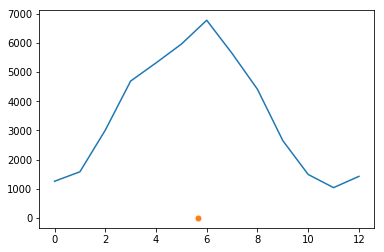

In [18]:
#core along spectral direction

#making array of h-alpha wl range
#for ref
#upperha = 1399
#lowerha = 1386
ha_section = flux_data[:,lowerha:upperha]

#collapsing halpha in the spectral direction (histogram like)
ha_section_sum = np.sum(ha_section,axis=0) 
ha_section2d = ha_section_sum[:,np.newaxis] #2d required to centroid

#centroiding
x_ha, y_ha = centroid_com(ha_section2d)
print('ha section centroid x,y:',x_ha,y_ha)


#verify by plots
plt.plot(ha_section2d)
plt.plot(x_ha,y_ha, '.', markersize=10)

#converting ha core wl to pixel value wrt fullccd

ha_core_spectralpix = x_ha + lowerha
print('pixel value of ha core along spectral direction is:',ha_core_spectralpix)


# H-alpha Centroids/Gaussians/Unc for each space row in Entire Target

In [22]:
#below for reference, uses full ccd wl range - first defined when applied DS
wl = np.array(ds_red10.pixtowl(np.arange(len(subimg2.data[::][0]))))
wl_shorter2 = wl[1396:1409] #isolate wl around h-alpha using full ccd plate wl range formerly 1387:1400


centroids_pix = []
mylist_ys2 = []
gfit_vals = []
stddev = []
means=[]
means_unc=[]


##below for reference- new is continuum subst target flux data (flux_data has 10 wl cut)
#b/c that 10 cut cutout those wl's and corresponding fluxes
print(wl_pix_correction)
print(np.shape(new))
new_short = new[:,1386:1399] #to go back to full ccd pix scale add ha_range_missing10[0] to pixel value


#gets halpha centroids/gaussians/uncertainities in target gal's range

for row in new_short: 
    
    #calculates centroids per row
    flux_fake2d2 = row[np.newaxis, :] #makes each row array into a fake2d
    centroid_xs, centroid_ys = centroid_com(flux_fake2d2)#finds center(x,y) of halpha for each row array
    mylist_ys2.append(centroid_ys)
    #print(centroid_xs, centroid_ys)
    centroids_pix.append(centroid_xs) #collects all halpha centroids per row
    
    #calculating errors per row via gaussian fit
    x = ar(range(len(row)))
    y = row
    mean = centroid_xs
    g_init = models.Gaussian1D(amplitude=max(y), mean=mean, stddev=2.)
    fit_g = fitting.LevMarLSQFitter()
    gaussian = fit_g(g_init, x, y)
    gfit_vals.append(gaussian)
    stddev.append(gaussian.stddev.value)
    means.append(gaussian.mean.value)

    #trying to get uncertainities per row via covariance matrix
    gaussian.param_cov = fit_g.fit_info['param_cov']
    means_unc.append(fit_g.fit_info['param_cov'])
    #means_unc.append(fit_g.fit_info['param_cov'][1][1]) #if throws error use line above instead
    
    
#end of for loop  - making things into arrays so easier to work with  
centroids_pix=np.array(centroids_pix) #halpha centroids (wl) array
gfit_vals = np.array(gfit_vals)  #all gaussian outputs in pixels
stddev = np.array(stddev) #std of gaussians in pixels
means = np.array(means) #gaussian peaks in pixels

#print(gaussian.param_cov,'next',means_unc)

#converting pixel values to be wrt full cdd

centroid_specpix_fullccd = centroids_pix + wl_pix_correction + ha_range_missing10[0]
gaussmax_specpix_fullccd = means + stddev + wl_pix_correction + ha_range_missing10[0]
gauss_mean = means + wl_pix_correction + ha_range_missing10[0]
#dont have to account for osciallations b/c used full ccd plate range b4 wl cut 4 h-alpha isolation
target_spacepix_fullccd = np.arange(len(centroids_pix)) + space_pix_correction


 
    
# #plotting
# plt.figure(figsize=(20,10))
# plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
# plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
# plt.plot(target_spacepix_fullccd,centroid_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
# plt.title('h-alpha centroids in pixel values',fontsize=35)
# plt.ylim(1393,1407)

10
(226, 4104)


(1398, 1410)

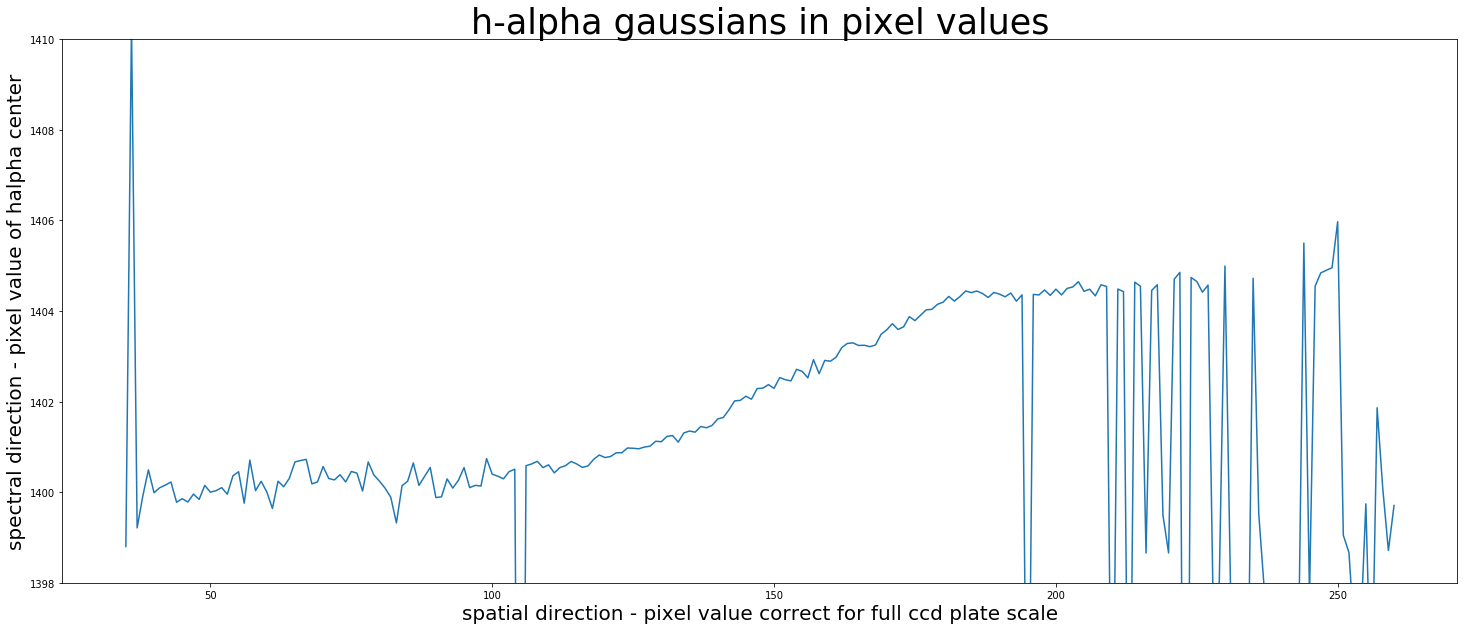

In [27]:
#plotting
plt.figure(figsize=(25,10))
plt.xlabel("spatial direction - pixel value correct for full ccd plate scale",fontsize=20)
plt.ylabel('spectral direction - pixel value of halpha center',fontsize=20)
plt.plot(target_spacepix_fullccd,gaussmax_specpix_fullccd)#(spaital pix index,corrected "wl" of centroid values (still in pix space))
plt.title('h-alpha gaussians in pixel values',fontsize=35)
#plt.ylim(1393,1407)
plt.ylim(1398,1410)

# Sanity Check of Errors

In [ ]:
#testing with test data, how fitter works and what outputs are

# Generate fake data
np.random.seed(0)
x = np.linspace(-5., 5., 200)
y = 3 * np.exp(-0.5 * (x - 1.3)**2 / 0.8**2)
y += np.random.normal(0., 0.2, x.shape)


# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x, y)
 
# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.plot(x, y, 'ko')
#plt.plot(x, t(x), label='Trapezoid')
plt.plot(x, g(x), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')
plt.axvline(g.mean)
plt.legend(loc=2)

g.mean 

In [ ]:
#tests to put into FOR LOOP way above
#using this one in for loop but theres still a few randow rows fit doesnt work for

test_row = 195 #162
#69/71, 159/161, 174/176, 183,186 209/211,    still good
#70,160, 175, 184, 185, 205, 210, 219,220,221, 225 bad 

x_gtest = ar(range(len(new_short[test_row]))) #independent data, space axis
y_gtest = new_short[test_row] #dependent data, flux values at space points



#works if change the amp,mean & std of ginit....but thatll change per row....so how??
g_init = models.Gaussian1D(amplitude=max(y_gtest), mean=6, stddev=2.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, x_gtest, y_gtest)
print(g)
# Plot the data with the best-fit model
#plt.figure(figsize=(8,5))
plt.plot(x_gtest,y_gtest, 'ko')
plt.plot(x_gtest, g(x_gtest), label='Gaussian')
plt.xlabel('Position')
plt.ylabel('Flux')

print('fwhm', g.fwhm, 'std*2', g.stddev*2)
#testing if mean gives the gaussian center x value...pretty close but very very slightly off
plt.axvline(g.mean)
plt.axvline(g.mean + g.stddev)
plt.axvline(g.mean - g.stddev)
plt.axhline(g.amplitude, color='g')


plt.axhline(g.amplitude/2)
plt.legend(loc=2)
#plt.ylim(59,66)
print('Dont think that the mean is gonna be good enough  - probably the reason for the errors when plotting - gaussian doesnt display same ha tilt')

# Spectral Core (aka Ha center wl)

In [ ]:
# Ha core wl another way
#try averaging the gaussian means

#first need to throw out outliers...clean data of points ridiculiously high due to bad fit
avg_of_uncleaned_gmeans = np.mean(means) 
made_up_mean_max = 3*avg_of_uncleaned_gmeans #using 3sigma logic for these limits
made_up_mean_min = -3*avg_of_uncleaned_gmeans #using 3sigma logic for these limits
valid_means = np.where((means >= made_up_mean_min) & (means <= made_up_mean_max))
cleaned_means = means[valid_means]
#print(cleaned_means) #removed those 3 outlier values

#getting an average value
avg_of_gmeans = np.mean(cleaned_means) 
print('shady avg pix of core:',avg_of_gmeans)

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
Hacorewl_specpix_fullccd = avg_of_gmeans + wl_pix_correction + ha_range_missing10[0]
print(Hacorewl_specpix_fullccd)

#applying ds to get pix to wl value
Ha_core_wl = ds_red10.pixtowl(Hacorewl_specpix_fullccd)*u.angstrom
print('this value fits in much better relative to the gaussian means. Ha "core" wl is:',Ha_core_wl)
#print(means)

In [ ]:
#possible test for errors in converting to full ccd size ----EITHER MISSING SOMETHING TO ADD OR NEED HIGHER HA WL CORE


Hacorewl_specpix_fullccd_TEST = avg_of_gmeans + ha_range_missing10[0] #removed the +10 just to see effect
Ha_core_wl_TEST = ds_red10.pixtowl(Hacorewl_specpix_fullccd_TEST)*u.angstrom

print('based on value of:',Ha_core_wl_TEST,'lesson learned defintely need a higher Halpha "core"')


In [ ]:
#doing above in more robust way - replacing means with std of means
#this fixes the sketchiness of my fake 3sigma clipping


#robust way to clean data
cleaned_means_robustway = sigma_clip(means, sigma=3)
#print(cleaned_means_robustway) # 3 values dropped out as expected = good


#unsure of next steps so gonna do 2 diff methods, keeping track via 1& 2 labels

#1st way
#is this necessary? dont think so, it should be done inside sigma_clip fcn. but wrote myself a note that erik
#said to replace means with the std of the means
std_of_means_cleaned = np.std(cleaned_means_robustway)
print("std dev of means:",std_of_means_cleaned)

#2nd method is i believe a core/avg value should come out of sigma clipping
avg_of_gmeans_robustway2 = np.mean(cleaned_means_robustway)
print("robust2:",avg_of_gmeans_robustway2, "maybe not method 2 b/c this is the exact same as my hack")



#robust method 2 was correct
''' 

#a 3rd idea
std_of_means_uncleaned = np.std(means) #but this is only one value so how do u get a mean?
robust3 = np.mean(std_of_means_uncleaned)
print('robust3:', robust3)

#just remembered a 4th way of cutting gaussian mean array to zoom in closer to galaxy core, so edges dont throw off things b/c of asymmetry
#only used 100 pixs around exact middle - may not be close enough to "true core" yet but just trying it
endlim = int((len(means)/2) + 50)
startlim = int((len(means)/2) - 50)
zoomed_in_around_core_means = means[startlim:endlim]
#note that this cut removed the outliers so no cleaning needed
robust4 = np.std(zoomed_in_around_core_means)
print('robust4:',robust4)

#a 5th way b/c robust4 is still pretty low
robust5 = np.mean(zoomed_in_around_core_means)
print('robust5:',robust5,'this one seems to be the best, but did it move it in the right direction.....')

#a 6th way -a mix of 4&5 with sigclipping
cleaned_zoomed_means = sigma_clip(zoomed_in_around_core_means, sigma=3)
robust6 = np.mean(cleaned_zoomed_means)
print('robust6:', robust6) #just verifies that sig clipping wasnt necessary for THIS target

#a 7th way just to see what median gives
robust7 = np.median(cleaned_zoomed_means) #hybrid of prior methods by using that array
print('robust7:',robust7) #this is a shift in the right direction too!


#an 8th way with unzoomed but cleaned data
mean_of_gmeans8 = np.mean(cleaned_means_robustway)
upper_limit8 = mean_of_gmeans8 + std_of_means_cleaned
lower_limit8 = mean_of_gmeans8 - std_of_means_cleaned
robust8 = upper_limit8/lower_limit8 #this formula came from my notes from last meeting
print('robust8:',robust8)
 
#a 9th way b/c maybe do need that zoom
mean_of_gmeans9 = np.mean(cleaned_zoomed_means)
std_of_means_cleanedzoomed = np.std(cleaned_zoomed_means)
upper_limit9 = mean_of_gmeans9 + std_of_means_cleanedzoomed
lower_limit9 = mean_of_gmeans9 - std_of_means_cleanedzoomed
robust9 = upper_limit9/lower_limit9 #this formula came from my notes from last meeting
print('robust9:',robust9) #better but still wrong direction shift

'''

#correcting avg Ha wl pixel value to reflect its place on the full ccd scale
#Hacorewl_specpix_fullccd_robustway1 = std_of_means_cleaned + wl_pix_correction + ha_range_missing10[0]
#Hacorewl_specpix_fullccd_robustway8 = robust8 + wl_pix_correction + ha_range_missing10[0]
#print(Hacorewl_specpix_fullccd_robustway1)

#these two used zoomed data- need to correct for? no b/c zoomed in spatial axis not spectral
#Hacorewl_specpix_fullccd_robustway5 = robust5 + wl_pix_correction + ha_range_missing10[0]
#Hacorewl_specpix_fullccd_robustway7 = robust7 + wl_pix_correction + ha_range_missing10[0]
#print(wl_pix_correction, ha_range_missing10[0])


#passing through ds
#Ha_core_wl_robustway1 = ds_red10.pixtowl(Hacorewl_specpix_fullccd_robustway1)*u.angstrom
#Ha_core_wl_robustway5 = ds_red10.pixtowl(Hacorewl_specpix_fullccd_robustway5)*u.angstrom
#Ha_core_wl_robustway7 = ds_red10.pixtowl(Hacorewl_specpix_fullccd_robustway7)*u.angstrom
#Ha_core_wl_robustway8 = ds_red10.pixtowl(Hacorewl_specpix_fullccd_robustway8)*u.angstrom


#print("this is the 1st robust way of finding the Ha central wl value of:", Ha_core_wl_robustway1)


In [ ]:
#using robust method 2 but also decreasing # of means used when calculating Ha-core-wl 


#first reduce means array length using spatial core pixel as the "center" to zoom in on
endlim = int(core_avgcentroids + 1)
startlim = int(core_avgcentroids - 1)
print(startlim, endlim)

zoomed_in_around_core_means = means[startlim:endlim]


#robust way to clean data
cleaned_zoomed_in_means = sigma_clip(zoomed_in_around_core_means, sigma=3)


#unsure of next steps so gonna do 2 diff methods, keeping track via 1& 2 labels



#2nd method is i believe a core/avg value should come out of sigma clipping
avg_of_zoomed_in_gmeans = np.mean(cleaned_zoomed_in_means)
print("avg_of_zoomed_in_gmeans:",avg_of_zoomed_in_gmeans)

#getting to correct ccd scale -used zoomed data but no correction for that b/c zoomed in spatial axis not spectral
Hacorewl_specpix_fullccd_zoomed_in_means = avg_of_zoomed_in_gmeans + wl_pix_correction + ha_range_missing10[0]

#pass thru ds

Ha_core_wl_fromzoomed_means = ds_red10.pixtowl(Hacorewl_specpix_fullccd_zoomed_in_means)*u.angstrom

print(Ha_core_wl_fromzoomed_means)

In [ ]:
plt.plot(zoomed_in_around_core_means)
plt.axhline(avg_of_zoomed_in_gmeans)
print('have learned that main core wl centering problem due to useing a simply division by 2 to get center of array')

# Generating Fake target gaussian data -- Come back and try to fix below

In [ ]:
#generating fake target data that's all gaussian- so can expect specific results
x_fakeg, y_fakeg = np.mgrid[0:100, 0:15]
mock_data = np.exp(-0.5*((x_fakeg-(50+y_fakeg/10))/2.0)**2)
mock_data

In [ ]:
plt.figure(figsize=(15,20))
plt.imshow(mock_data.T)

# Converting Pixels --> kpc 

In [ ]:
#centering around core first

#below for reference
#wl_pix_correction2 is pix of ha centroid in full plate scale
#target_spacepix_fullccd is row pix of each centroid
#spatial_core_pix is pixel value of the galaxy core in full plate scale


#still in pixel space
distance_pix_wrtcore = target_spacepix_fullccd - spatial_core_pix #for core wl using full ccd
distance_pix_wrtcore_sections = target_spacepix_fullccd - core_from_sections #for core wl using 2 sections around Halpha


In [ ]:
#actual converting for loop CENTROIDS pixels to kpc
#good for core defined by 2 sections around halpha

#converts pixels to kpc (distance profile)
arcmins_sections =[]
distances_sections=[]
more_sections = []


#converts pix to kpc and saves as quantity list
for i in distance_pix_wrtcore_sections:
    r_in_arcmin = 1*u.arcmin
    redplatescale = 0.293*u.arcsec/u.pixel
    dbsp_pix_equiv = u.pixel_scale(redplatescale)
    r_in_pixel = i*u.pixel
    r_in_arcmin = r_in_pixel.to('arcmin', dbsp_pix_equiv)
    #print(r_in_arcmin)
    distance = 37*u.Mpc # distance of object (host) from us
    rad_to_arcmin = (1*u.rad).to('arcmin')
    r_in_kpc = ((r_in_arcmin/rad_to_arcmin)*distance).to("kpc") #gets radians*distancefromus for gal width in kpc
    #print(r_in_kpc)
    more_sections = r_in_kpc #/ (1*u.kpc)
    #print(more_sections)
    distances_sections.append(more_sections.value)
distances_sections = np.array(distances_sections)
#print(distances_sections);

In [ ]:
#good for core defined using 2 sections around halpha

plt.figure(figsize=(25,10))
plt.plot(distances_sections * u.kpc,centroid_specpix_fullccd)
plt.title('H-alpha Centroids in pixels with distance converted_core from sections',fontsize=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)


plt.ylim(1394,1410)

In [ ]:
plt.figure(figsize=(25,10))
print(np.shape(gaussmax_specpix_fullccd))
plt.title('Ha Gaussian centers in pixels - with distance converted_core from sections', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('spectral direction in pixels',fontsize=20)
plt.plot(distances_sections * u.kpc,gaussmax_specpix_fullccd)
plt.ylim(1398,1410)

In [ ]:
#finding y-value corresponding to zero in x-axis for above gaussian ha graph
hopefully = np.interp(0, gaussmax_specpix_fullccd, distances_sections * u.kpc)
print(hopefully)

In [ ]:
plt.figure(figsize=(25,10))
print(np.shape(gaussmax_specpix_fullccd))
plt.title('Ha Gaussian centers entirely in pixel space', SIZE=25)
plt.plot(target_spacepix_fullccd,gaussmax_specpix_fullccd)
plt.ylim(1398,1410)
print('-see similar Halpha centroid tilt=good')

# Applying DS --pix to wl associations for velocity axis (spectral) 

In [ ]:
# this applys ds to pix values to get true wl's

#for ref 
#gaussmax_specpix_fullccd = means + stddev + wl_pix_correction + 1386
#gauss_mean = means + wl_pix_correction + ha_range_missing10[0]
#centroid_specpix_fullccd = centroids_pix + wl_pix_correction + ha_range_missing10[0]
#Hacorewl_specpix_fullccd = avg_of_gmeans + wl_pix_correction + ha_range_missing10[0]



centroids_wl = ds_red10.pixtowl(centroid_specpix_fullccd)*u.angstrom
gauss_meanWstd_wl  = ds_red10.pixtowl(gaussmax_specpix_fullccd)*u.angstrom
gauss_means_wl = ds_red10.pixtowl(gauss_mean)*u.angstrom
core_wl_sections = ds_red10.pixtowl(core_from_sections)*u.angstrom
core_wl = ds_red10.pixtowl(spatial_core_pix)*u.angstrom
#for reference b/c did above in spectral core calculation
#Ha_core_wl = ds_red10.pixtowl(Hacorewl_specpix_fullccd)*u.angstrom

# Converting Pixels ----> velocity

In [ ]:
#using redshift formula to get velocity
#((obs_wl - true_wl)/true_wl)* c = velocity
#except what we want is  v_not relative to core - v_of core

#velocities NOT relative to the core
v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities
v_spec_centroids = (centroids_wl /(6563*u.angstrom) -1) * const.c #centroid velocities
print('core', Ha_core_wl)
v_core = ((Ha_core_wl/(6563*u.angstrom)) -1) * const.c #core velocity
#print('vccore',v_core,'vspec gauss',np.shape(v_spec_gaussians),'core_wl_sections',core_wl_sections)

#velocities relative to the core from sections
y_axis_Gvelocity = (v_spec_gaussians - v_core).to('km/s')  #gaussian
y_axis_Cvelocity = (v_spec_centroids - v_core).to('km/s') #centroids

print('vel of Ha wl "core":',v_core)
#print('v_spec_gaussians',v_spec_gaussians)
#print('Gauss vel', y_axis_Gvelocity, 'Centroid vel', y_axis_Cvelocity)
#print('"y_axis_Gvelocity" is gaussian velocities and "y_axis_Cvelocity" is centroid velocities')
#print(gauss_means_wl)

In [ ]:
plt.figure(figsize=(25,10))
plt.title('Rotation Curve via Halpha Gaussians', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.plot(distances_sections * u.kpc, y_axis_Gvelocity)
plt.ylim(-250,250) #used right spectral/ha core
plt.plot(0,0,'.', markersize=25)

# Calculating ErrorBars


In [ ]:
#method to obtain sigma = subt velocities of (mean+sigma) - mean = sigma

#taking sqrt of unc to get a true sigma
sigma_gauss_pix = np.sqrt(np.abs(means_unc))
#first getting to correct ccd pix scale so can pass into ds
means_Wsigma_fullccd = means + sigma_gauss_pix + wl_pix_correction + ha_range_missing10[0]
print('ha',ha_range_missing10[0])
#passing into ds
means_max_wl = ds_red10.pixtowl(means_Wsigma_fullccd)*u.angstrom
#making into velocities
v_means_withsigma = (means_max_wl/ (6563*u.angstrom)-1) * const.c 
print('means_max_wl',means_max_wl)
#for ref...already did same steps for means w/o sigma
#gauss_mean = means + wl_pix_correction + ha_range_missing10[0]
#gauss_means_wl = ds_red10.pixtowl(gauss_mean)*u.angstrom
#v_spec_gaussians = ((gauss_means_wl/(6563*u.angstrom)) -1) * const.c #gaussian velocities


#extracting sigma velocity
v_unc = (v_means_withsigma - v_spec_gaussians).to('km/s') 
np.reshape(v_unc,(226,))
print('v_unc', np.shape(v_unc))##,v_unc)

In [ ]:
#rotation curve with gaussians with errorbars
plt.figure(figsize=(25,10))
print(np.shape(v_unc))
print('v_unc',np.shape(v_unc))
#chopping last value b/c in sigma array = -inf
print(np.shape(distances_sections[:-1] * u.kpc), type(distances_sections[:-1] * u.kpc))
print(np.shape(y_axis_Gvelocity[:-1]),type(y_axis_Gvelocity[:-1]))
print(np.shape(v_unc[:-1]),type(v_unc[:-1]))


arr = np.asarray #need to avoid setting array element as sequence
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity[:-1]), yerr=arr(v_unc[:-1]))
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)


plt.axhline(0)
plt.ylim(-50,50)
plt.xlim(-1,1)

In [ ]:
#testing plot with new robust1 method for finding y-axis zeropoint

#first pix-velocity conversion for new core
#v_core_robustway1 = ((Ha_core_wl_robustway1/(6563*u.angstrom)) -1) * const.c #core velocity
#y_axis_Gvelocity_robustway1 = (v_spec_gaussians - v_core_robustway1).to('km/s')  #gaussian

#plotting
plt.figure(figsize=(25,10))
#plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_robustway1[:-1]), yerr=arr(v_unc[:-1]))
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars___1ST ROBUST METHOD', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
#plt.ylim(-250,550)
print('clearly this is worse')

In [ ]:
#testing robust5 method
''' 
#first pix-velocity conversion for new core
v_core_robustway5 = ((Ha_core_wl_robustway5/(6563*u.angstrom)) -1) * const.c #core velocity
y_axis_Gvelocity_robustway5 = (v_spec_gaussians - v_core_robustway5).to('km/s')  #gaussian

#plotting
plt.figure(figsize=(25,10))
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_robustway5[:-1]), yerr=arr(v_unc[:-1]))
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars___5th ROBUST METHOD', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)
print('this is lower, so it shifted the core location the wrong direciton..')
'''

In [ ]:
#testing robust7 method
'''
#first pix-velocity conversion for new core
v_core_robustway7 = ((Ha_core_wl_robustway7/(6563*u.angstrom)) -1) * const.c #core velocity
y_axis_Gvelocity_robustway7 = (v_spec_gaussians - v_core_robustway7).to('km/s')  #gaussian

#plotting
plt.figure(figsize=(25,10))
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_robustway7[:-1]), yerr=arr(v_unc[:-1]))
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars___7th ROBUST METHOD ie median', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)
'''

In [ ]:
#testing robust8 method
'''
#first pix-velocity conversion for new core
v_core_robustway8 = ((Ha_core_wl_robustway8/(6563*u.angstrom)) -1) * const.c #core velocity
y_axis_Gvelocity_robustway8 = (v_spec_gaussians - v_core_robustway8).to('km/s')  #gaussian

#plotting
plt.figure(figsize=(25,10))
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_robustway8[:-1]), yerr=arr(v_unc[:-1]))
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars___8th ROBUST METHOD', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)
'''

In [ ]:
#THIS TEST JUST VERIFIES THAT THE CALCULATED CENTER"CORE" OF HA WL IS TOO LOW

#Ha_core_wl_TEST = mynumber #originally
mynumber = 6616.5*u.angstrom #IDEALLY MY HA_CORE_WL COMES OUT TO LIKE THIS


#first pix-velocity conversion for new core
v_core_TEST = ((mynumber/(6563*u.angstrom)) -1) * const.c #core velocity
y_axis_Gvelocity_TEST = (v_spec_gaussians - v_core_TEST).to('km/s')  #gaussian

#plotting
plt.figure(figsize=(25,10))
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_TEST[:-1]), yerr=arr(v_unc[:-1]))
plt.title('Rotation Curve via Halpha Gaussians with ErrorBars___TEST', SIZE=25)
plt.xlabel('RADIUS in Kpc',fontsize=20)
plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(0,0,'.',markersize=20)
plt.ylim(-250,250)

In [ ]:
#first pix-velocity conversion for new core
v_core_fromzoomed_means = ((Ha_core_wl_fromzoomed_means/(6563*u.angstrom)) -1) * const.c #core velocity
y_axis_Gvelocity_fromzoomed_means = (v_spec_gaussians - v_core_fromzoomed_means).to('km/s')  #gaussian

#plotting
plt.figure(figsize=(25,10))
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_fromzoomed_means[:-1]), yerr=arr(v_unc[:-1]),ecolor='cyan')
plt.title('Rotation Curve for SAGA Satellite Catch22-1', SIZE=30) #via Halpha Gaussians with ErrorBars___fromzoomed_means', SIZE=25)
#plt.xlabel('RADIUS in Kpc',fontsize=20)
#plt.ylabel('VELOCITY in km/s',fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(-250,250)

#plt.plot(0,0,'.',markersize=20)
plt.savefig('catch-22_rotationcurve.pdf', format='pdf', dpi=1000)
#use below limits instead to zoom in on core, orange dot isnt fully on data, very close but no
#plt.ylim(-10,11)
#plt.xlim(-.2,.2)

# Mass Modeling

In [ ]:
#eriks eqt 5
''' 
sigma = 1/(v_unc**2) * (u.km**2/u.s**2) #stellar velocity dispersion




#eriks eqt
length = (len(distances_sections[:-1]))
#print(length,type(length))
#r_half= np.arange(0,length,1)#main variable
r_half = np.linspace(distances_sections[0],distances_sections[-2],225)
r_M = 2 #transition radius
#print('half',type(r_half),np.shape(r_half),r_half,'M',type(r_M), np.shape(r_M),r_M)
ravg_M = np.log(r_half/ r_M)# #avg radius
alpha = r_half**2#slope of center transition region, needs to be exponential
beta = 1 #slope of flat areas
omega = 4#width of transition zone
Mavg = ravg_M * ((alpha + beta)/2) + (sigma[:-1] - ravg_M*(alpha - beta)) * (np.arctan(ravg_M / omega))/np.pi
print(Mavg[2:])  #1st vale is bad 'nan', 2nd val negative so chop Mavg[2:]
xlength = np.arange(0,len(distances_sections[2:-1]),1)#np.arange(0,len(Mavg[2:]),1)
print(np.shape(distances_sections[:-1]), np.shape(Mavg[2:]),np.shape(Mavg[2:]))
print('why isnt this s-shaped yet, tweak more parms')
plt.plot(xlength,Mavg[2:])
'''

In [ ]:
#simple model first



In [ ]:
#eriks model eqt 5

@custom_model #very necessary line
def eriksmodel(r, alpha=.1, beta=.1, sigma=250, omega=.4):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)


#fit model to data
m_init = eriksmodel()
fit = LevMarLSQFitter()
#print('here',m_init)
m = fit(m_init, arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_fromzoomed_means[:-1]),weights=(1/arr(v_unc[:-1])**2))
print(m)
#plot data & fit
plt.figure(figsize=(15,5))
plt.plot(distances_sections[:-1], y_axis_Gvelocity_fromzoomed_means[:-1], color='k')
plt.plot(distances_sections[:-1], m(distances_sections[:-1]), color='b')
#plt.ylim(-230,200) #zooms to see data good, if fit is good
plt.ylim(-1000,2000) #to see whole effect of param playing on fit line

In [ ]:
#same cell as above with diff values for w comparisons
@custom_model #very necessary line
def eriksmodel(r, alpha=.1, beta=.1, sigma=250, omega=0):
    return (r * ((alpha + beta)/2) + (sigma - r*(alpha - beta)) * (np.arctan(r / omega))/np.pi)


#fit model to data
m_init = eriksmodel()
fit = LevMarLSQFitter()
#print('here',m_init)
m = fit(m_init, arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_fromzoomed_means[:-1]),weights=(1/arr(v_unc[:-1])**2))

#plot data & fit
plt.figure(figsize=(15,5))
plt.plot(distances_sections[:-1], y_axis_Gvelocity_fromzoomed_means[:-1], color='k')
plt.plot(distances_sections[:-1], m(distances_sections[:-1]), color='b')
plt.ylim(-230,200) #zooms to see data good, if fit is good
#plt.ylim(-1000,2000) #to see whole effect of param playing on fit line
print('notice the asymmetry tho')

In [ ]:
#from astropy to figure out how to make a custom model

@custom_model #very necessary line
def sum_of_gaussians(x, amplitude1=1., mean1=-1., sigma1=1.,
                        amplitude2=1., mean2=1., sigma2=1.):
    return (amplitude1 * np.exp(-0.5 * ((x - mean1) / sigma1)**2) +
            amplitude2 * np.exp(-0.5 * ((x - mean2) / sigma2)**2))

# Generate fake data
np.random.seed(0) #keeps the same random numbers generated with each run
x = np.linspace(-5., 5., 200)
m_ref = sum_of_gaussians(amplitude1=2., mean1=-0.5, sigma1=0.4,amplitude2=0.5, mean2=2., sigma2=1.0) #shape of fake data
print(m_ref)
y = m_ref(x) + np.random.normal(0., 0.1, x.shape)

# Fit model to data INSERT SAGA DATA HERE
m_init = sum_of_gaussians()
fit = LevMarLSQFitter()
m = fit(m_init, x, y)

# Plot the data and the best fit
plt.plot(x, y, 'o', color='k')
plt.plot(x, m(x))


In [ ]:
#code from laura to play with estimating fixed values for free params in eriks model 

alpha = 0.01
beta = 0.01
s = 10
omega = 3
cst = 2

xx = np.linspace(-25, 25, 101)
yy = xx * (alpha + beta)/2 + (s - xx*(alpha - beta)) * np.arctan(xx/omega)/np.pi + cst

plt.figure()
plt.plot(xx, yy, "k")
plt.plot(xx, 0*xx + cst, "--b")
plt.plot(xx, 0*xx + cst + s/2, "--r")
plt.plot(xx, 0*xx + cst - s/2, "--r")
plt.xlim(xx.min(), xx.max())
plt.show()

In [ ]:
#mass estimator from velocities 
R_e = #Mcconnie table 3, (8) r_h pc
sigma_m = #s_0.5 original eqt w/o sqrt2...think for saga this is calculated velocites/sqrt2

#from wolf
M_half = 4 * u.G**-1 * sigma_mcc**2 * R_e

In [ ]:
#determining best slope for alpha value above
x = np.arange(0,100,1)
m = x**3
b = 5#yintercpt
y = m*x + b
plt.plot(x,y)

In [ ]:
#my try fit any line to rot curve

# #rot curve
# plt.figure(figsize=(25,10))
# plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_fromzoomed_means[:-1]), yerr=arr(v_unc[:-1]))
# #plt.ylim(-250,250)
# plt.ylim(-500,500)

# #fit line
# testdata = y_axis_Gvelocity_fromzoomed_means[:-1]
# xtest = np.linspace(arr(distances_sections[:-1])[0],arr(distances_sections[:-1])[-1],225) #evenly divides wl range into 50 even len sections
# #x = np.array(np.linspace(0, testdata, 4))
# #xp = np.arange(arr(distances_sections[:-1])[0],arr(distances_sections[:-1])[-1],1) #lists pixels by index

# #print('length',len(arr(distances_sections[:-1])),len(y_axis_Gvelocity_fromzoomed_means[:-1]),'len',len(xp), len(testdata),len(xtest))
# #print('xp',xp,'d', distances_sections,'kpc',arr(distances_sections[:-1])[-1])
# please = np.polyfit(xtest,testdata, 3, w = (1/v_unc[:-1]**2),cov=True)
# please2 = np.polyfit(xtest,testdata, 3, w = (1/arr(v_unc[:-1])**2))#worse

# print('1',type(please),please,'2',please2,'please',please[1],'please2',please[1][1][1])


# poly = np.poly1d(np.polyfit(xtest,testdata, 3, w= (1/arr(v_unc[:-1])**2))) #fitting a straight line for now, can try higher order poly to improve
# plt.title('Rotation Curve for SAGA Satellite Catch22-1',size=30)
# plt.xticks(fontsize=25)
# plt.yticks(fontsize=25)
# plt.plot(xtest,poly(xtest),'--')
# plt.ylim(-200,200)
# plt.savefig('Catch22_1amplitudefitted.pdf', format='pdf', dpi=1000)


# #print('poly(xtest)',poly(xtest))
# fitline = poly(xtest)
# type(fitline)
# #type(poly)

# #print('?',poly.??)

In [ ]:
#finding amplitude

#might need for error later but whatevver
''' 
print('1',type(please),please,'please',please[1],please[1][1][1])
print('fitted line',len(fitline))
matrix = please[1]
diagonal = [please[1][0][0],please[1][1][1],please[1][2][2],please[1][3][3]]
variance = np.sum(diagonal)
stdev = np.sqrt(variance)
print('std',stdev)
'''
#for i in fitline:
#    print(i)


print(len(fitline),'velr=0',fitline[119])


#amplitude
amp = (np.max(fitline) - np.min(fitline))/2
print("Catch22-1's average velocity is ",amp,"km/s")


In [ ]:
#trying to fit a line to rot curve using masked code
plt.figure(figsize=(25,10))
plt.errorbar(arr(distances_sections[:-1] * u.kpc), arr(y_axis_Gvelocity_fromzoomed_means[:-1]), yerr=arr(v_unc[:-1]))
plt.ylim(-250,250)

#v_unc[:-1]

#fit a line (avoiding osccillations at ends)
smodel = Mavg[2:]
x_model=np.arange(0,len(distances_sections[:-1]),1)
#fitmsk = (120<space_pix_correction2)&(space_pix_correction2 <175)
y_model=y_axis_Gvelocity_fromzoomed_means[:-1]
fitter = modeling.fitting.LevMarLSQFitter()#space_pix_correction2)#,[linemodel,[y],[x]])
distances_sections_model = distances_sections[:-1] * (u.s/u.km)
#print('help',distances_sections_model)
#soemthing wrong with smodel b/c only works if linear, comparing it to anak-2

#print('unc',np.shape(v_unc[:-1]),distances_sections_model,y_axis_Gvelocity_fromzoomed_means[:-1])


#smodel = smodel * u.km/u.s

#np.reshape(distances_sections_model,(225,))
#np.reshape(y_axis_Gvelocity_fromzoomed_means[:-1],(225,))
#np.reshape(v_unc[:-1],(225,))

print('dis',distances_sections_model[:],'2',y_axis_Gvelocity_fromzoomed_means[:-1],'3',v_unc[:-1])

linemodel_model = fitter(smodel, distances_sections_model[:],y_axis_Gvelocity_fromzoomed_means[:-1],weights=arr(1/(v_unc[:-1])**2))
modwl_model = np.linspace(distances_sections_model[0], distances_sections_model[-1], 200)
#print(linemodel_model)
#print('xy', distances_sections_model)
print(linemodel_model(modwl_model))
plt.plot(modwl_model, linemodel_model(modwl_model))

In [ ]:
#trying to build an s-shaped model b/c eriks requires lots of reading to understand

xlist = np.arange(0,len(distances_sections_model),1)
print(np.shape(xlist))

model_sshape=[]
for i in xlist:
    if (i >= len(distances_sections_model)/3) & (i <= 2*(len(distances_sections_model)/3)):
        middle = i*2
    if i >= 2*(len(distances_sections_model)/3):
        highedge = i
    modeltest = m.tanh(i)
    model_sshape.append(modeltest)
#model_tanh = m.tanh(xlist)
print(model_sshape)
#plt.plot(xlist,model_sshape)
plt.plot(m.tanh(xlist))

In [ ]:
#what eqt is s shaped?

c=100
eqt = x**3 + x**2 + x+ c
print(np.shape(xlist),np.shape(eqt))
plt.plot(xlist[:-25],eqt)